In [1]:
library(arrow)
library(cowplot)
library(tidyverse)


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
✖ lubridate::stamp()    masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
gwas_summary_df <- read_parquet("data/gwas_summary/indirect_non_anon_vs_anon.parquet")
pheno_summary_df <- read_parquet("data/pheno_summary/indirect_non_anon_vs_anon.parquet")


summary_df <- gwas_summary_df |>
    inner_join(pheno_summary_df, by = c("kind", "phenotype", "k"), suffix = c("_gwas", "_pheno")) |>
    mutate(
        operator = if_else(kind == "boolean", str_extract(phenotype, "^([a-z]+)(?=_)"), "phecode"),
        kind = kind |> factor(levels = c("phecodes", "boolean"))
    )

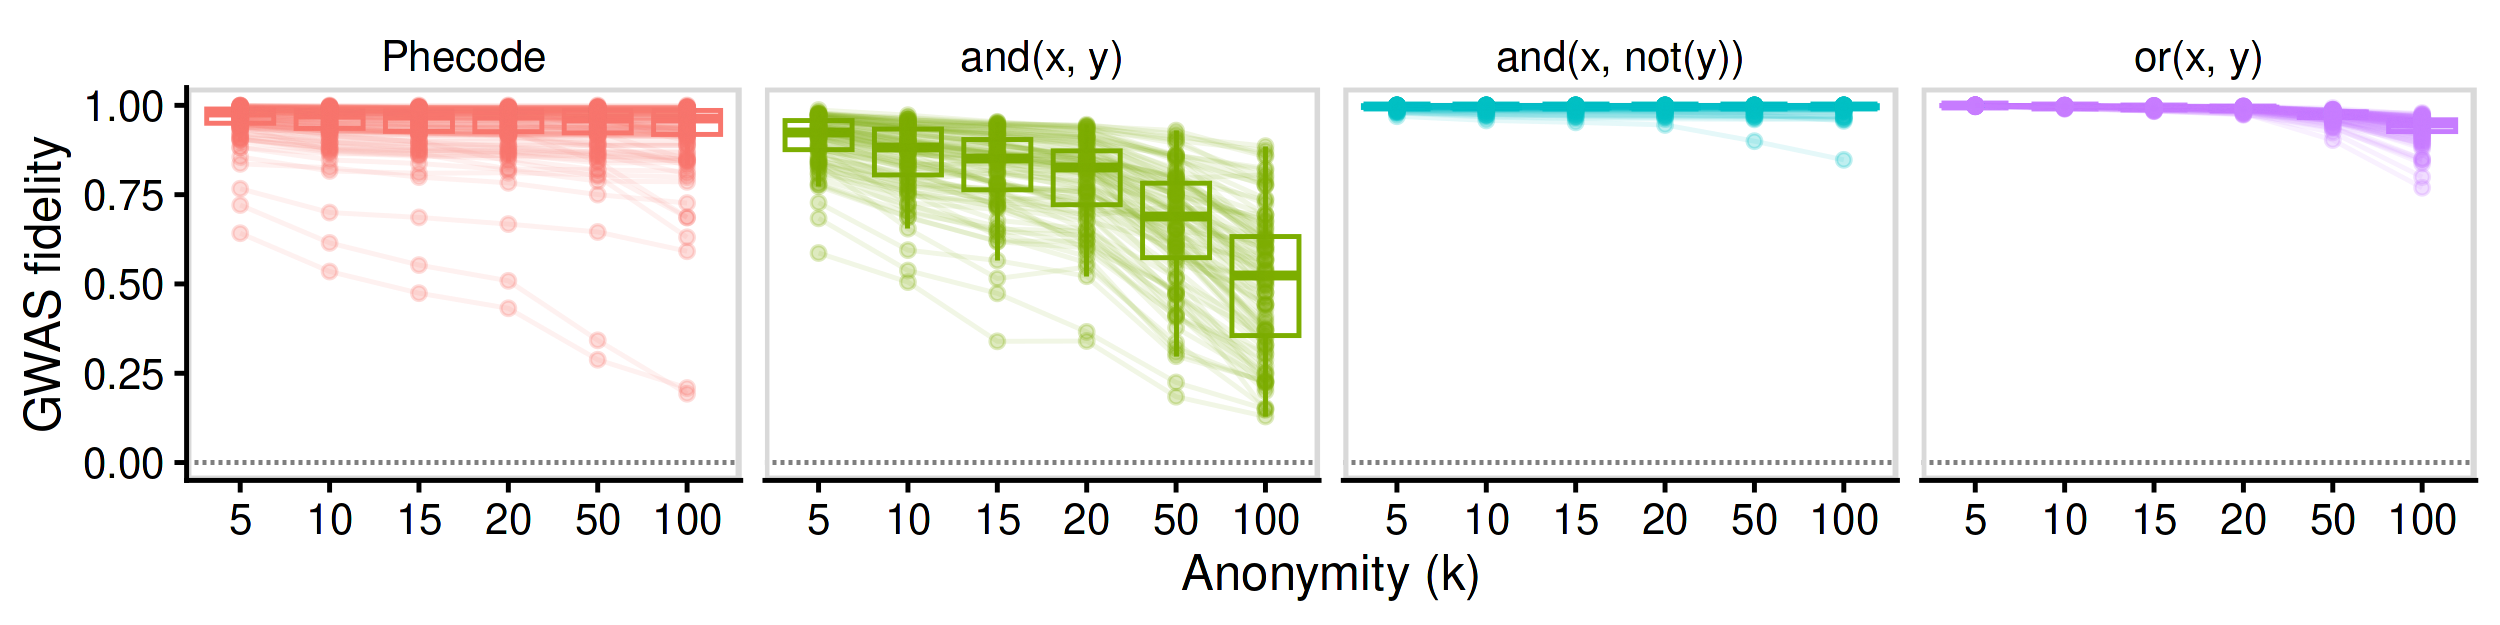

In [3]:
options(repr.plot.width = 10, repr.plot.height = 2.5, repr.plot.res = 250)

performance_vs_k_plot <- summary_df |>
    mutate(
        operator = operator |> 
            recode_factor(
                phecode = "Phecode",
                and = "and(x, y)",
                not = "and(x, not(y))",
                or = "or(x, y)",
            ),
        k = k |> as.integer() |> as.character() |> factor(levels = c("5", "10", "15", "20", "50", "100")),
    ) |>
    ggplot(aes(x = k, y = r_gwas, color = operator)) +
    geom_boxplot(aes(group = k), outlier.shape = NA) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray50") +
    geom_line(aes(group = phenotype), alpha = 0.1) +
    geom_point(alpha = 0.25) +
    facet_grid(cols = vars(operator)) +
    theme_cowplot() +
    panel_border() +
    theme(
        legend.position = "none",
        strip.background = element_blank(),
    ) +
    xlab("Anonymity (k)") +
    ylab("GWAS fidelity")

save_plot("img/performance-vs-k.png", performance_vs_k_plot, base_width = 10, base_height = 2.5, dpi = 400)

performance_vs_k_plot

In [4]:
library(magick)

a_img <- image_read("img/linearization-performance-marginal.png") |>
    image_crop(geometry = geometry_area(width = 1500))

a <- ggdraw() + draw_image(a_img)
b <- ggdraw() + draw_image(image_read("img/overall-performance-marginal.png"))
c <- ggdraw() + draw_image(image_read("img/performance-vs-k.png"))

Linking to ImageMagick 6.9.10.23
Enabled features: fontconfig, freetype, fftw, lcms, pango, webp, x11
Disabled features: cairo, ghostscript, heic, raw, rsvg

Using 128 threads



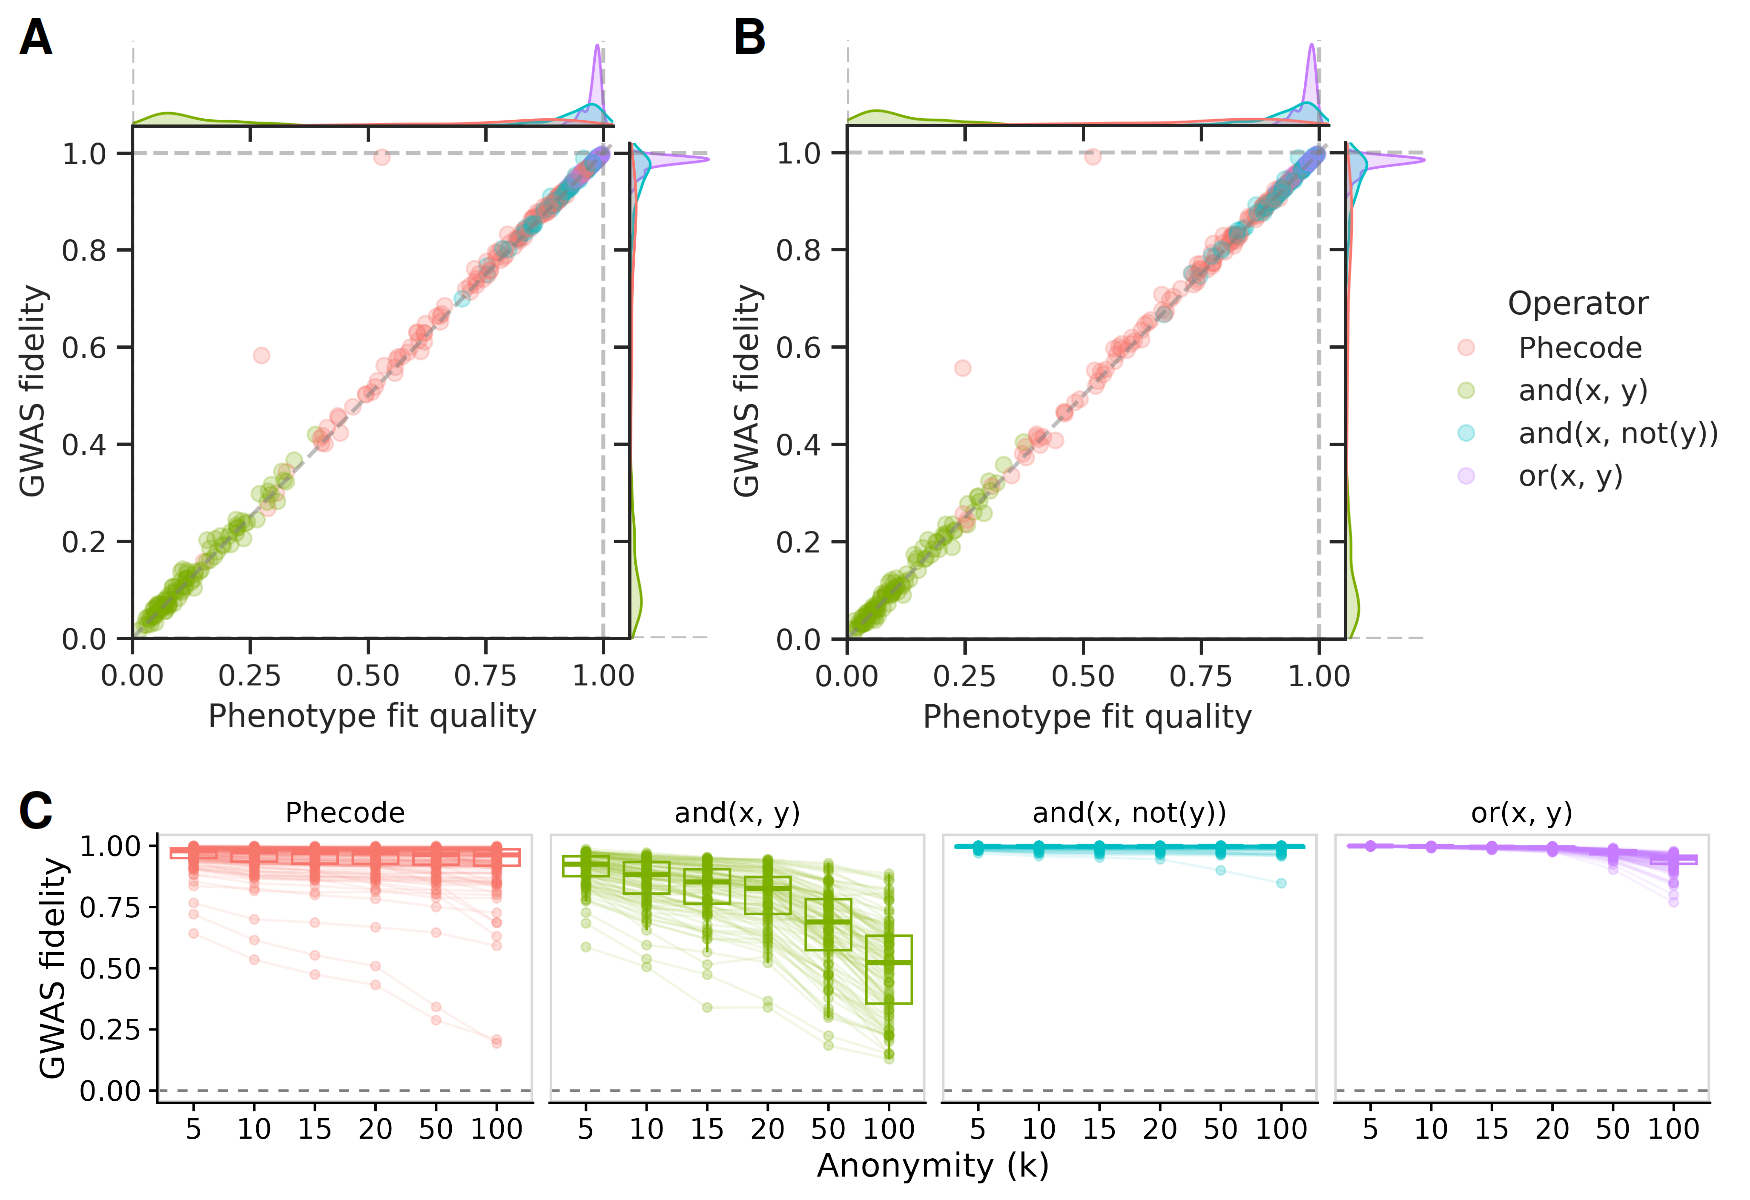

In [5]:
options(repr.plot.width = 7, repr.plot.height = 4.8, repr.plot.res = 250)

top_row <- plot_grid(a, b, labels = c("A", "B"), rel_widths = c(1, 1.45))
full_plot <- plot_grid(top_row, c, labels = c("", "C"), ncol = 1, rel_heights = c(1, 0.55))

save_plot("img/full.png", full_plot, base_width = 7, base_height = 4.8, dpi = 400)
full_plot